In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import random
import os
import time
from collections import defaultdict

In [2]:
# Чтение df, индексация стран

df = pd.read_excel("Data/dist_data.xls")
df = df[df['iso_o'] != df['iso_d']]

values = df.values

col_to_ind = dict(zip(df.columns, range(len(df.columns))))
id_to_iso = list(set(df['iso_o']))
n = len(id_to_iso)
iso_to_id = {}
for i, key in enumerate(id_to_iso):
    iso_to_id[key] = i

In [3]:
# Рассчёт расстояний

dist = np.array([[0.0] * n for i in range(n)])
dist_col = col_to_ind['dist']
values.T[dist_col] = values.T[dist_col] / values.T[dist_col].max()
for i in range(values.shape[0]):
    row = values[i]
    one = row[0]
    two = row[1]
    # (1 − Contiguity[2]) + (1 − CommonColonizer[]) + GeodesicDistanceij + GeneticDistanceij +
    # LinguisticDistanceij + ReligiousDistanceij
    d = (1 - row[col_to_ind['contig']]) + (1 - row[col_to_ind['comcol']]) + \
    row[col_to_ind['comlang_off']] + 0.1 * row[col_to_ind['dist']]
    dist[iso_to_id[one]][iso_to_id[two]] = d
dist = -dist

In [4]:
# Параметры

k = 3

In [5]:
# Проверка корректности входа

def is_close(a, b):
    return abs(a - b) < 1e-5

for i in range(n):
    for j in range(i):
        try:
            assert is_close(dist[i][j], dist[j][i])
        except AssertionError:
            print(i, j, dist[i][j], dist[j][i])
            dist[i][j] = dist[j][i] = (dist[i][j] + dist[j][i]) / 2
    try:
        assert dist[i][i] == 0
    except AssertionError:
        print(i, i, dist[i][i])
with open("input.txt", "w") as file:
    print(n, k, file=file)
    for i in range(n):
        print(*dist[i], file=file)

In [6]:
# Запуск алгоритма

with open("output.txt", "w") as file:
    print('#', end='', file=file)
time.sleep(0.5)

simple = True

if simple:
    open_file = "simple"
else:
    open_file = "difficult"
os.startfile("executable\\" + open_file)

while True:
    time.sleep(0.1)
    with open("output.txt") as file:
        s = file.readline().strip()
        if s != "#":
            break

Used colors:
(220, 190, 255)
(145, 30, 180)
(245, 130, 48)
Нет никаких данных о стране SAH в plot_output
Нет никаких данных о стране COD в plot_output
Нет никаких данных о стране ATF в plot_output
Нет никаких данных о стране TLS в plot_output
Нет никаких данных о стране PSX в plot_output
Нет никаких данных о стране ROU в plot_output
Нет никаких данных о стране ATA в plot_output
Нет никаких данных о стране CYN в plot_output
Нет никаких данных о стране SOL в plot_output
Нет никаких данных о стране SRB в plot_output
Нет никаких данных о стране MNE в plot_output
Нет никаких данных о стране KOS в plot_output
Нет никаких данных о стране SDS в plot_output


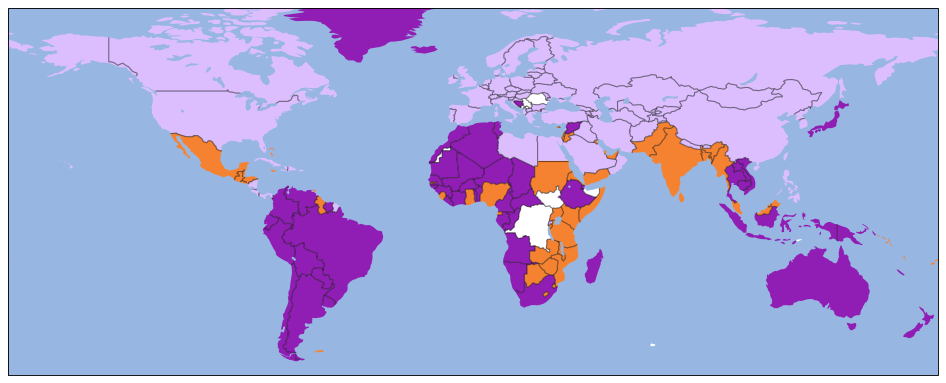

In [7]:
# Чтение коалиций из output.txt и отрисовка карты

time.sleep(0.1)

# Чтение коалиций
with open("output.txt") as file:
    id_to_coalition = list(map(int, file.readline().split()))

# Подбор цветов
colors = [(230, 25, 75), (60, 180, 75), (255, 225, 25), (0, 130, 200), (245, 130, 48),
          (145, 30, 180), (70, 240, 240), (240, 50, 230), (210, 245, 60), (250, 190, 212),
          (0, 128, 128), (220, 190, 255), (170, 110, 40), (255, 250, 200), (128, 0, 0),
          (170, 255, 195), (128, 128, 0), (255, 215, 180), (0, 0, 128), (128, 128, 128)]
random.shuffle(colors)
good_colors = [(220, 190, 255),
               (145, 30, 180),
               (245, 130, 48),
               (128, 128, 0),
               (255, 250, 200)]
for c in good_colors:
    colors.remove(c)
colors = good_colors + colors
colors = [tuple(map(lambda x: x / 255, color)) for color in colors]
while len(colors) < k:
    colors.append((random.random(), random.random(), random.random()))
print("Used colors:")
for i in range(k):
    print(tuple(map(lambda x: round(x * 255), colors[i])))

# Отрисовка карты
plt.figure(figsize=(15, 10), dpi=80)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-150, 60, -25, 60])

shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()
for country in countries:
    iso_name = country.attributes['ADM0_A3']
    if iso_name in iso_to_id:
        color = colors[id_to_coalition[iso_to_id[iso_name]]]
    else:
        color = (1, 1, 1)
        print(f"Нет никаких данных о стране {iso_name} в plot_output")
    ax.add_geometries([country.geometry], ccrs.PlateCarree(),
                      facecolor=color,
                      label=country.attributes['ADM0_A3'])
# ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
# ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=.5)
ax.add_feature(cartopy.feature.LAKES, alpha=0.95)
#         ax.add_feature(cartopy.feature.RIVERS)
plt.show()